In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Importing plotly failed. Interactive plots will not work.


In [2]:
#Importing data
Shanghai = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShanghaiPM20100101_20151231.csv")


In [3]:
Shanghai.dropna(axis=0, how="any",inplace=True)

In [4]:
# from datetime import datetime
Shanghai['Time'] = pd.to_datetime(Shanghai['year'].map(str) +"/"+ Shanghai['month'].map(str) +"/"+ Shanghai['day'].map(str)+" "+Shanghai['hour'].map(str)+":00:00")
#Beijing

In [5]:
by_hour = Shanghai.groupby(['Time']).mean()
by_hour.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
Time,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,26305,2013,1,1,0,4,66.0,70.0,71.0,-5.0,69.00,1023.0,0.0,60.0,0.0,0.0
2013-01-01 01:00:00,26306,2013,1,1,1,4,67.0,76.0,72.0,-5.0,69.00,1023.0,0.0,62.0,0.0,0.0
2013-01-01 03:00:00,26308,2013,1,1,3,4,73.0,78.0,74.0,-4.0,74.41,1023.0,0.0,65.0,0.0,0.0
2013-01-01 04:00:00,26309,2013,1,1,4,4,75.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,68.0,0.0,0.0
2013-01-01 05:00:00,26310,2013,1,1,5,4,73.0,78.0,80.0,-4.0,80.04,1023.0,-1.0,70.0,0.0,0.0


In [6]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2015-12-31 13:00:00', '2015-12-31 14:00:00',
               '2015-12-31 15:00:00', '2015-12-31 16:00:00',
               '2015-12-31 17:00:00', '2015-12-31 18:00:00',
               '2015-12-31 19:00:00', '2015-12-31 20:00:00',
               '2015-12-31 21:00:00', '2015-12-31 22:00:00'],
              dtype='datetime64[ns]', name='Time', length=26279, freq='H')


In [7]:
by_hour['Time'] = by_hour.index
by_hour['Time']

Time
2013-01-01 00:00:00   2013-01-01 00:00:00
2013-01-01 01:00:00   2013-01-01 01:00:00
2013-01-01 02:00:00   2013-01-01 02:00:00
2013-01-01 03:00:00   2013-01-01 03:00:00
2013-01-01 04:00:00   2013-01-01 04:00:00
                              ...        
2015-12-31 18:00:00   2015-12-31 18:00:00
2015-12-31 19:00:00   2015-12-31 19:00:00
2015-12-31 20:00:00   2015-12-31 20:00:00
2015-12-31 21:00:00   2015-12-31 21:00:00
2015-12-31 22:00:00   2015-12-31 22:00:00
Freq: H, Name: Time, Length: 26279, dtype: datetime64[ns]

In [8]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20150101030000'))]

In [9]:
data_13 = data_13.set_index(data_13.index).asfreq('H')

In [10]:
#########################################################################################################

In [11]:
#Creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data_13, label='PM_US Post')

features_and_target = pd.concat([X, y], axis=1)

In [12]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PM_US Post
Time,,,,,,,,,
2013-01-01 03:00:00,3,1,1,1,2013,1,1,1,78.0
2013-01-01 04:00:00,4,1,1,1,2013,1,1,1,77.0
2013-01-01 05:00:00,5,1,1,1,2013,1,1,1,78.0
2013-01-01 06:00:00,6,1,1,1,2013,1,1,1,77.0
2013-01-01 07:00:00,7,1,1,1,2013,1,1,1,80.0


In [13]:
###############################################################################################################

In [14]:
#Plotting the Features to see trends

##Power demand has strong daily and seasonal properties.
##Day of week also seems to show differences in peaks.

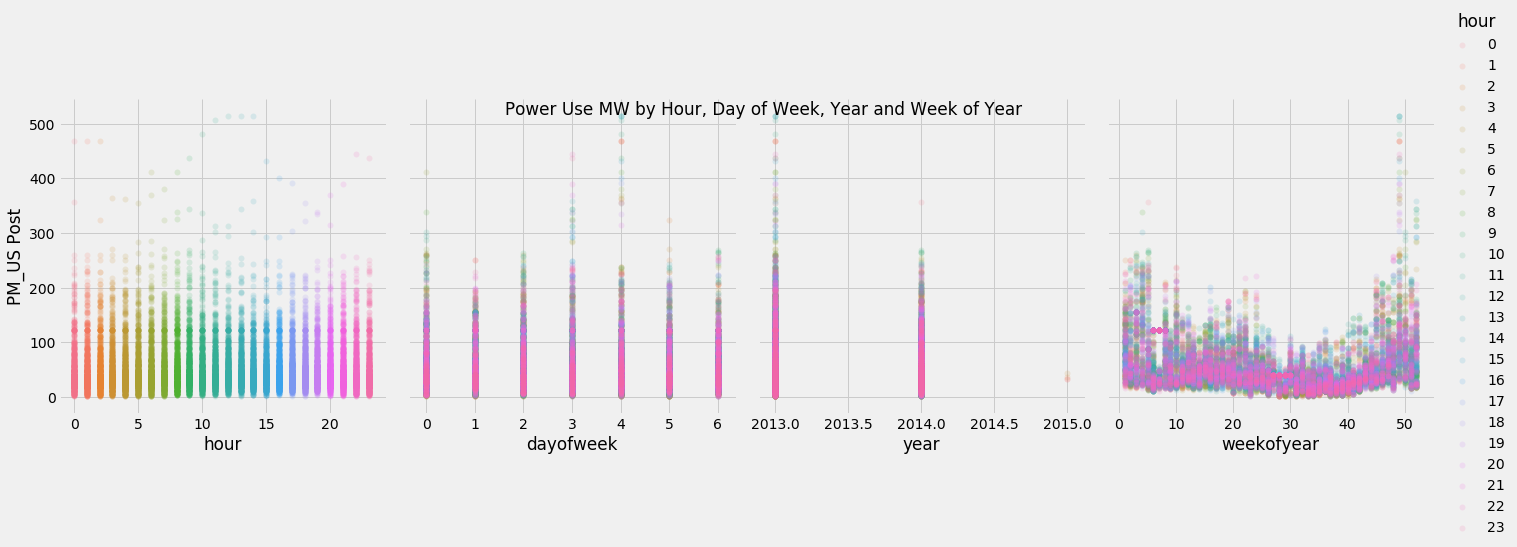

In [15]:
 sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PM_US Post',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [16]:
###############################################################################################################

In [17]:
#Train/Test Split
##Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [18]:
split_date = '2014-06-01 03:00:00'
data_13_train = data_13.loc[data_13.index <= split_date].copy()
data_13_test = data_13.loc[data_13.index > split_date].copy()

In [19]:
###############################################################################################################

In [20]:
# Format data for prophet model using ds and y
## Use parameter drop=True which not create new column with index but remove it

data_13_train.reset_index(drop=True) \
    .rename(columns={'Time':'ds',
                     'PM_US Post':'y'}).head()

,No,year,month,day,hour,season,PM_Jingan,y,PM_Xuhui,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,ds
0,26308.0,2013.0,1.0,1.0,3.0,4.0,73.0,78.0,74.0,-4.0,74.41,1023.0,0.0,65.0,0.0,0.0,2013-01-01 03:00:00
1,26309.0,2013.0,1.0,1.0,4.0,4.0,75.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,68.0,0.0,0.0,2013-01-01 04:00:00
2,26310.0,2013.0,1.0,1.0,5.0,4.0,73.0,78.0,80.0,-4.0,80.04,1023.0,-1.0,70.0,0.0,0.0,2013-01-01 05:00:00
3,26311.0,2013.0,1.0,1.0,6.0,4.0,74.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,71.0,0.0,0.0,2013-01-01 06:00:00
4,26312.0,2013.0,1.0,1.0,7.0,4.0,73.0,80.0,84.0,-4.0,86.15,1024.0,-2.0,0.0,0.0,0.0,2013-01-01 07:00:00


In [21]:
# Setup and train model and fit
model = Prophet()
model.fit(data_13_train.reset_index(drop=True) \
              .rename(columns={'Time':'ds',
                               'PM_US Post':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [22]:
# Predict on training set with model
df_test_fcst = model.predict(df=data_13_test.reset_index(drop=True) \
                                   .rename(columns={'Time':'ds'}))

In [23]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-06-01 04:00:00,61.863655,3.268644,110.630681,61.863655,61.863655,-4.164482,-4.164482,-4.164482,-1.506404,-1.506404,-1.506404,-2.658078,-2.658078,-2.658078,0.0,0.0,0.0,57.699173
1,2014-06-01 05:00:00,61.868613,5.468097,111.688572,61.868613,61.868613,-3.254624,-3.254624,-3.254624,-0.762693,-0.762693,-0.762693,-2.491931,-2.491931,-2.491931,0.0,0.0,0.0,58.613989
2,2014-06-01 06:00:00,61.873570,5.942880,111.892953,61.873570,61.873570,-1.780784,-1.780784,-1.780784,0.535665,0.535665,0.535665,-2.316449,-2.316449,-2.316449,0.0,0.0,0.0,60.092786
3,2014-06-01 07:00:00,61.878528,9.165594,114.813958,61.878528,61.878528,-0.211206,-0.211206,-0.211206,1.922649,1.922649,1.922649,-2.133855,-2.133855,-2.133855,0.0,0.0,0.0,61.667322
4,2014-06-01 08:00:00,61.883486,10.123580,114.397792,61.883486,61.883486,0.821223,0.821223,0.821223,2.767634,2.767634,2.767634,-1.946411,-1.946411,-1.946411,0.0,0.0,0.0,62.704709


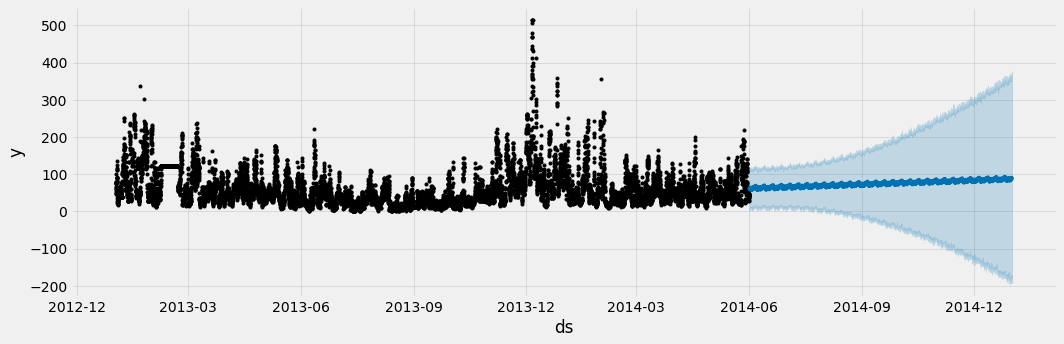

In [24]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

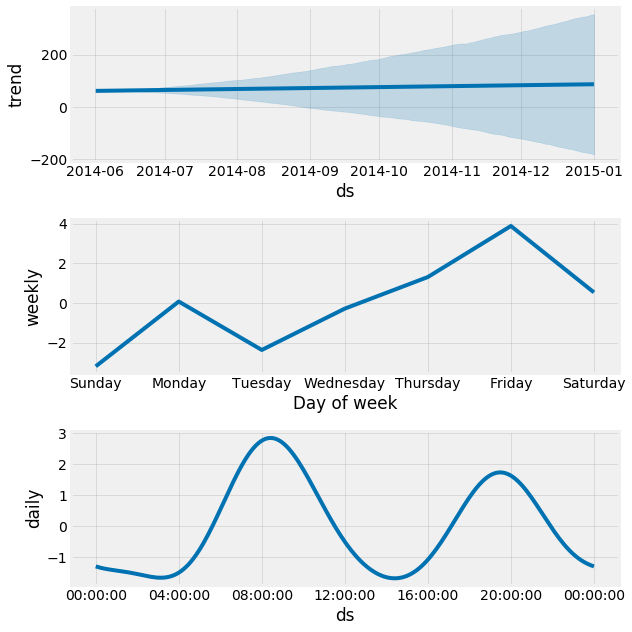

In [25]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

In [26]:
###############################################################################################################

In [27]:
#Compare Forecast to Actuals

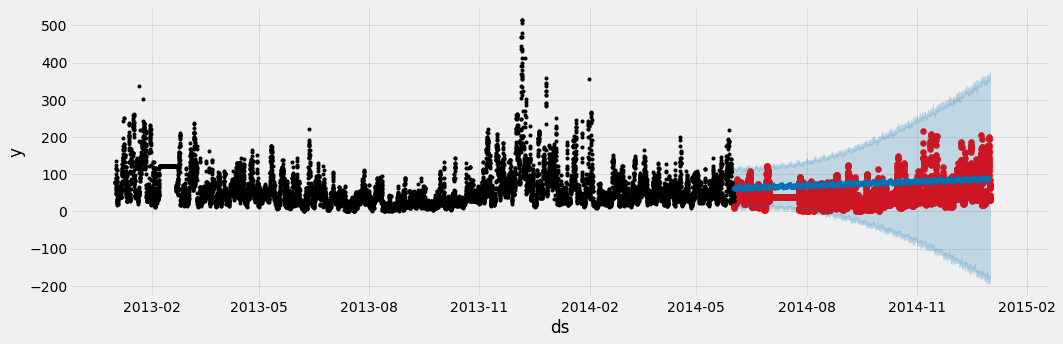

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

In [29]:
#Look at first month of predictions

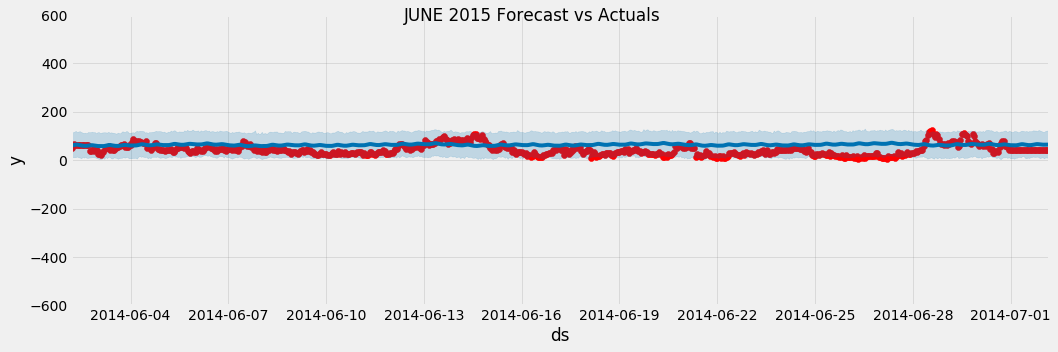

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20140602040000'),
              upper=pd.to_datetime('20140702040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('JUNE 2015 Forecast vs Actuals')

In [31]:
###############################################################################################################

In [32]:
#Single Week of Predictions

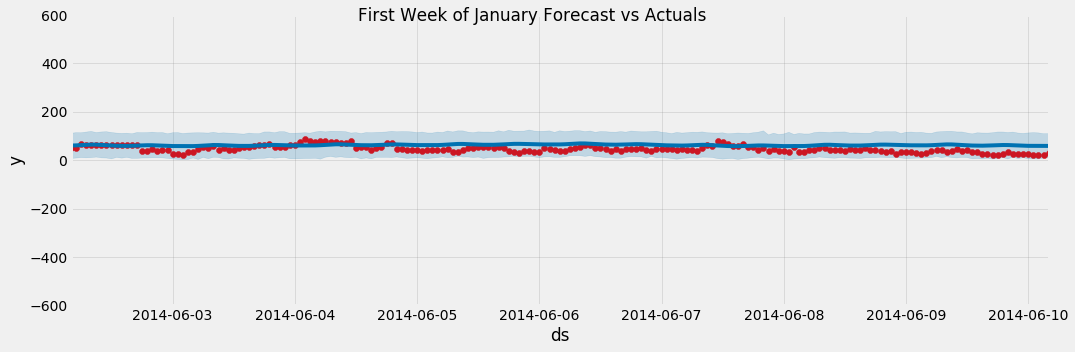

In [33]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20140602040000'),
              upper=pd.to_datetime('20140610040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('First Week of January Forecast vs Actuals')